<h2>Music014/102 Lab2: Tonality and Pitch Space</h2>
<h2>Prof. Michael Casey</h2>
<h2>Dartmouth College</h2>

In [9]:
# import libraries that we will use
from pylab import * 
import glob
%matplotlib inline
rcParams['figure.figsize'] = 14, 8

In [2]:
# Tonal analysis utility functions. These operate on a 128 x T piano-roll score matrix.

pitch_classes = ['C','C#','D','Eb','E','F','F#','G','G#','A','Bb','B']
pc_labels = tile(pitch_classes, 13) # Make pitch labels for whole range of piano roll

def pitch_distribution(mtx, tstr=''):
    """                                                                                                          
    Given a piano-roll matrix, 128 pitches x T beats, plot the pitch class histogram                           
    """
    i_min, i_max = where(mtx.mean(1))[0][[0,-1]]
    pd = mtx[i_min:i_max+1,:].sum(1)
    stem(arange(i_max+1-i_min),pd)
    ttl = 'Pitch Distribution'
    if tstr: ttl+=': '+tstr
    title(ttl,fontsize=16)    
    nskip = 3 if mtx.shape[0]>12 else 1 # figure out how many labels to show
    t=xticks(arange(0,i_max+1-i_min,nskip),pc_labels[i_min:i_max+1:nskip],fontsize=14)
    xlabel('Pitch Class', fontsize=14)
    ylabel('Frequency', fontsize=14)
    ax = axis()
    axis(xmin=-0.5)
    grid()
    return pd, arange(i_min,i_max+1) # return pitch frequencies and ranges

def fold_octaves(mtx, tstr=''):
    """                                                                                                          
    Given a piano-roll matrix, 128 pitches x T beats, fold and sum values into a single octave
    """
    noctaves = 10 # We only have 10 complete octaves, last few very high pitches are discarded
    return mtx[:noctaves*12].reshape(noctaves,12,-1).sum(0)

def plot_mtx(mtx=None, ttl=None, newfig=False, cbar=False, **kwargs):
    """                                                                                                          
      plot ascore matrix as a piano roll                     
    """
    if mtx is None or type(mtx) != ndarray:
        raise ValueError('First argument, mtx, must be a array')
    if newfig: figure()
    dbscale = kwargs.pop('dbscale', False)
    bels = kwargs.pop('bels',False)
    norm = kwargs.pop('norm',False)
    normalize = kwargs.pop('normalize',False)
    origin=kwargs.pop('origin','lower')
    aspect=kwargs.pop('aspect','auto')
    interpolation=kwargs.pop('interpolation','nearest')
    cmap=kwargs.pop('cmap',cm.gray_r)
    clip=-100.
    X = scale_mtx(mtx, normalize=normalize, dbscale=dbscale, norm=norm, bels=bels)
    i_min, i_max = where(X.mean(1))[0][[0,-1]]
    X = X[i_min:i_max+1].copy()
    if dbscale or bels:
        if bels: clip/=10.
        imshow(clip(X,clip,0),origin=origin, aspect=aspect, interpolation=interpolation, cmap=cmap, **kwargs)
    else:
        imshow(X,origin=origin, aspect=aspect, interpolation=interpolation, cmap=cmap, **kwargs)
    if title:
        title(ttl,fontsize=16)
    if cbar:
        colorbar()
    nskip = 3 if mtx.shape[0]>12 else 1 # figure out how many labels to show
    yticks(arange(0,i_max+1-i_min,nskip),pc_labels[i_min:i_max+1:nskip],fontsize=14)
    xlabel('Tactus', fontsize=14)
    ylabel('MIDI Pitch', fontsize=14)
    grid()


<h4>In this lab you will:</h4>
    1. Analyze music using both audio features and symbolic (score-based) features
    2. Analyze a musical corpus by sampling from multiple works
    3. Extract the latent geometry in tonal music 

<h1>Tonality</h1>
<h2>1. Pitch Distributions (Histograms) show the frequency of occurence of each note in a score </h2>

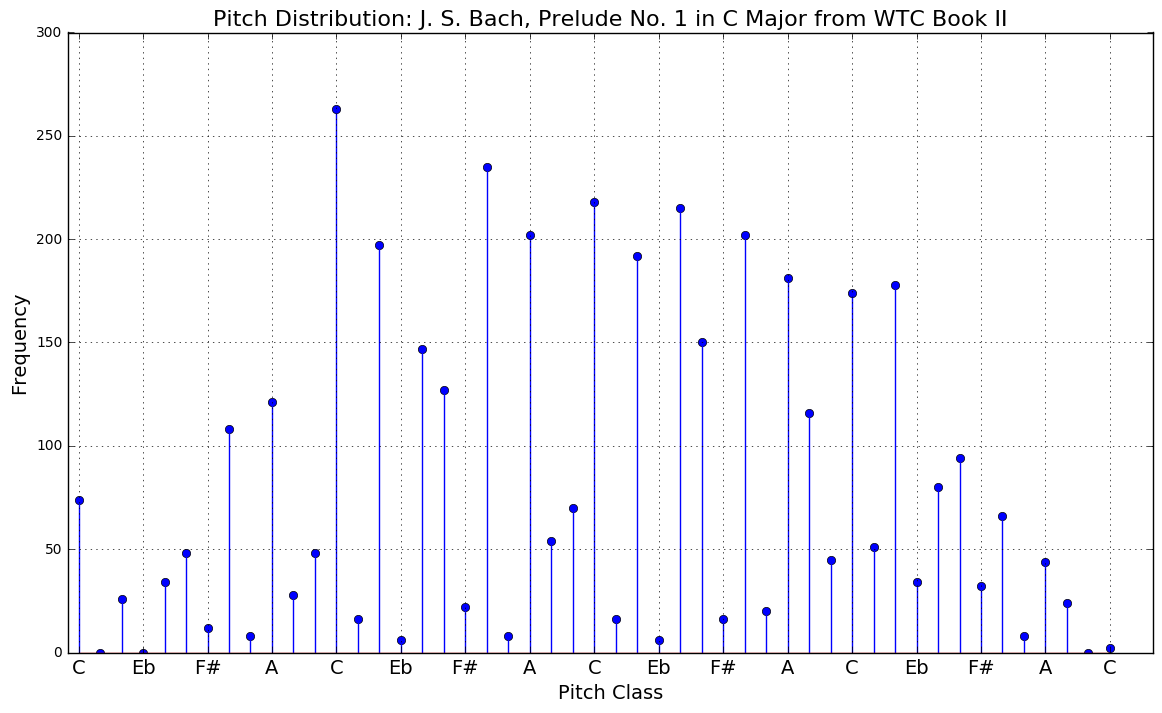

In [4]:
# Summarize a work as a pitch histogram, showing only the range of active pitches
# Load the first prelude in Book II of J.S. Bach's WTC
prelude1 = loadtxt('BachWTC1/49.ascii')
pd = pitch_distribution(prelude1, 'J. S. Bach, Prelude No. 1 in C Major from WTC Book II')

<h2>Octave Folding</h2> 

The above plot treats pitches in separate octaves as different pitches

It is more usual in tonal music analysis to ignore pitch height (octave) and to focus on pitch class
Here, we fold the score into a single octave and plot the pitch histogram for one octave


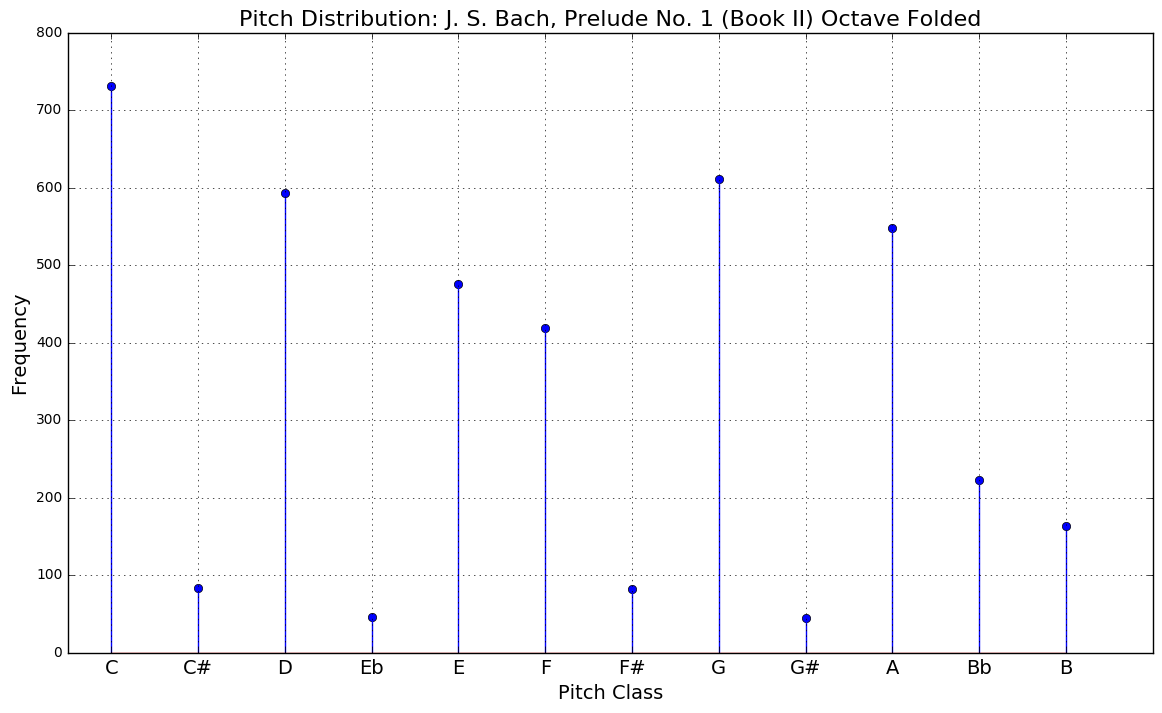

In [5]:
# Fold the above score into a single octave score matrix
prelude1_octave = fold_octaves(prelude1)
pd = pitch_distribution(prelude1_octave, 'J. S. Bach, Prelude No. 1 (Book II) Octave Folded')

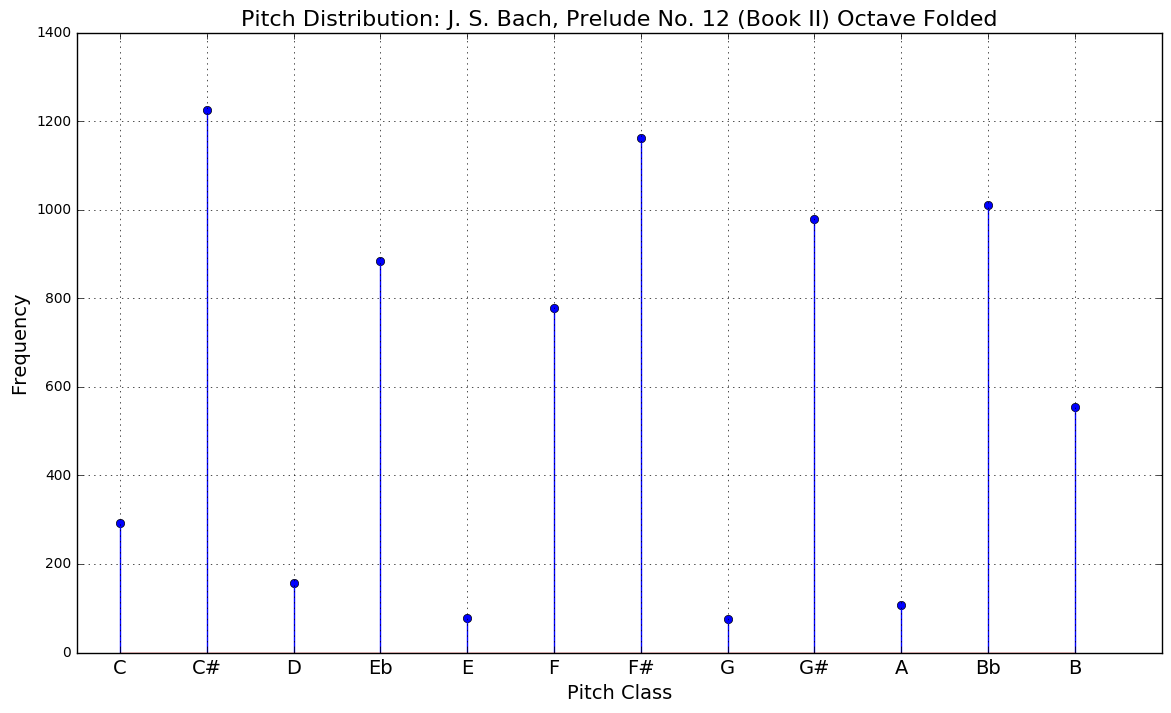

In [6]:
# Let's load a work in another key, say F# Major
prelude13 = loadtxt('BachWTC1/73.ascii')
prelude13_octave = fold_octaves(prelude13)
pd = pitch_distribution(prelude13_octave, 'J. S. Bach, Prelude No. 12 (Book II) Octave Folded')

<h2>Transposing a score</h2>

It is difficult to compare the pitch distribution of the Prelude in C Major with that of the Prelude in F# Major
because, obviously, they are in different keys.

To mitigate against the difference in keys, we can transpose a score by "rolling" the pitch axis downwards and circularly so that the pitches correspond to the key of C Major. For example, the Prelude No. 13 in F# Major can be rolled (transposed) by -6 half steps in the following way:


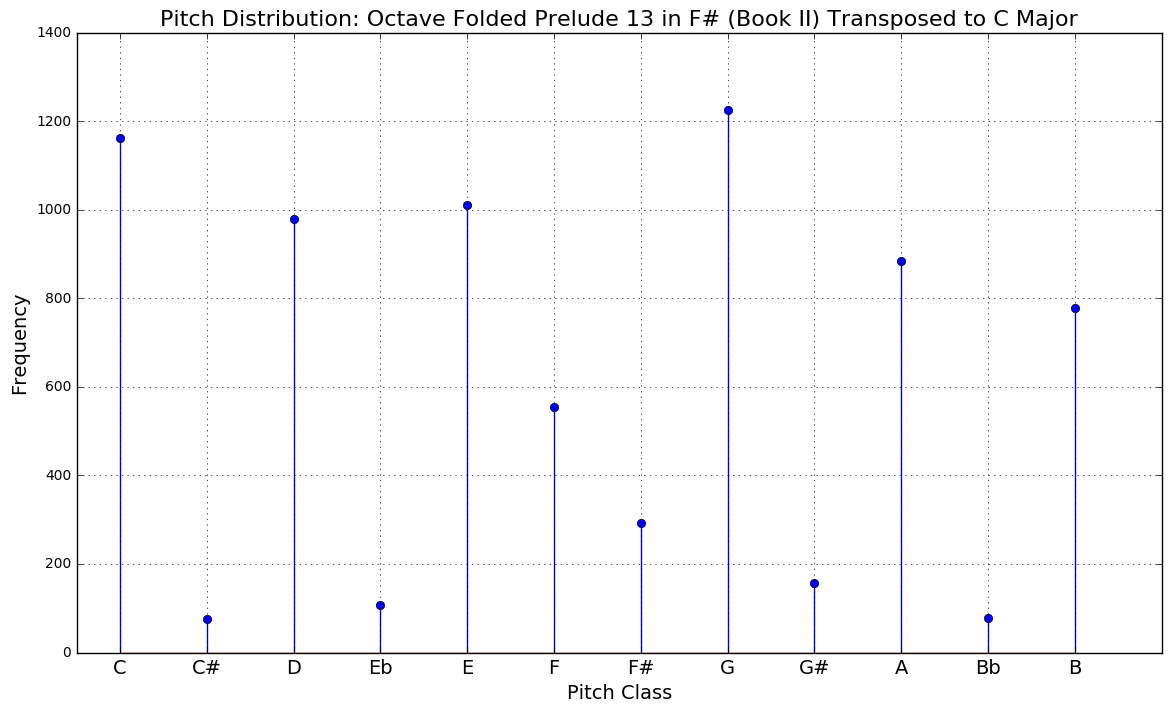

In [7]:
# Transpose the F# Prelude into the key of C Major
prelude13_transposed = roll(prelude13, -6, axis=0) # Roll the pitches (axis=0) down by six half steps (-6)
prelude13_transposed_octave = fold_octaves(prelude13_transposed)
pd = pitch_distribution(prelude13_transposed_octave, 'Octave Folded Prelude 13 in F# (Book II) Transposed to C Major')

<h1>Working with a Corpus</h1>
<h4>So far we have considered only one work at a time. Here we will investigate working with a corpus of works: the Well Tempered Clavier (WTC) Books 1 and 2 by J. S. Bach</h4>
<h4>WTC is organized into two books with 48 works each: a prelude and a fugue for every major and minor key in pitch class order: ['C','C#','D',...].</h4>
<h4>The WTC folder contains MIDI piano roll matrix representations of each work.</h4>

<h4>BOOK 1:</h4>
<ul>
<li>1.ascii = Prelude No. 1 in C Major
<li>2.ascii = Fugue No. 1 in C Major
<li>3.ascii = Prelude No. 2 in C Minor
<li>4.ascii = Fugue No. 2 in C Minor
<li>5.ascii = Prelude No. 3 in C# Major
<li>6.ascii = Fugue No. 3 in C# Major
<li>7.ascii = Prelude No. 4 in C# Minor
<li>8.ascii = Fugue No. 4 in C# Minor
<li>...
<li>47.ascii - Prelude No. 24 in B Minor
<li>48.ascii = Fugue No. 24 in B Minor
</ul>
<h4>BOOK 2:</h4>
<ul>
<li>49.ascii = Prelude No. 25 in C Major
<li>59.ascii = Fugue No. 25 in C Major
<li>...
<li>95.ascii = Prelude No. 48 in B Minor
<li>96.ascii = Fugue No. 48 in B Minor
</ul>



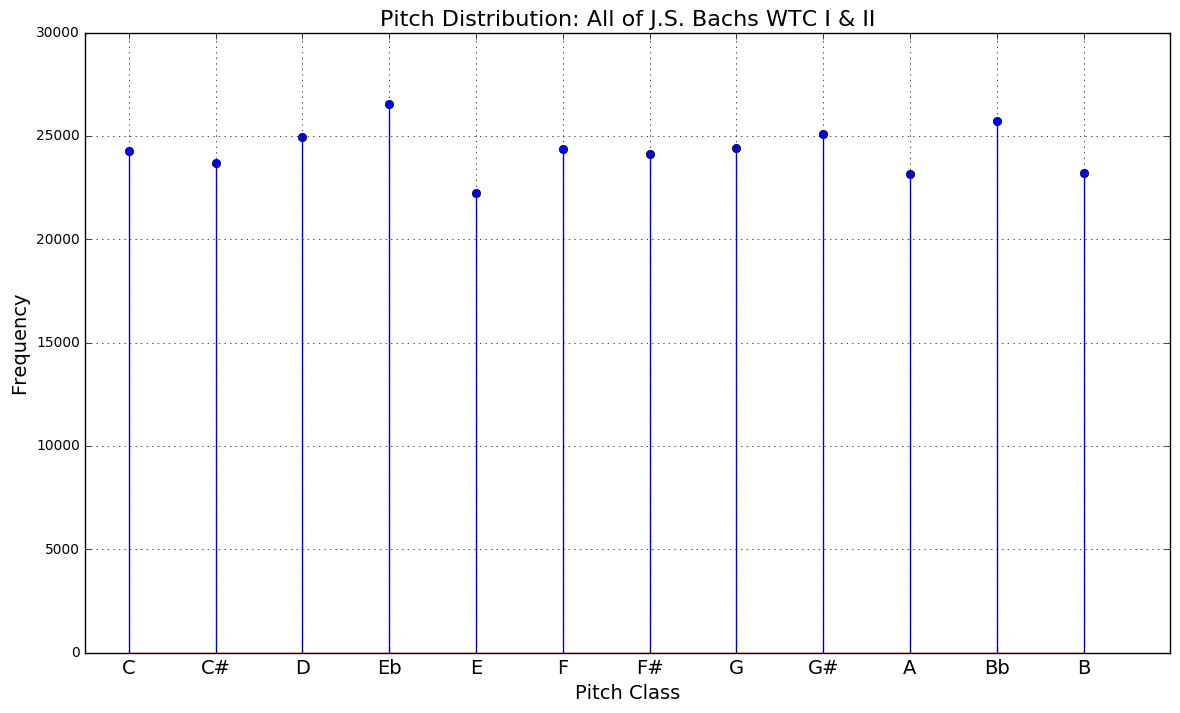

In [18]:
# LOAD ALL WTC works and show as a folde octaves pitch histogram
# We do this by loading each work into a list and then horizonally stacking them
# so that we get a 128 x T matrix, with T the total number of tacti (beats) in WTC I & II
allworks = [loadtxt(f) for f in sorted(glob.glob('BachWTC1/*.ascii'))] # Load ALL works
allworks_octave = fold_octaves( hstack(allworks) ) # stack horizontally and fold
pd = pitch_distribution(allworks_octave, "All of J.S. Bachs WTC I & II")

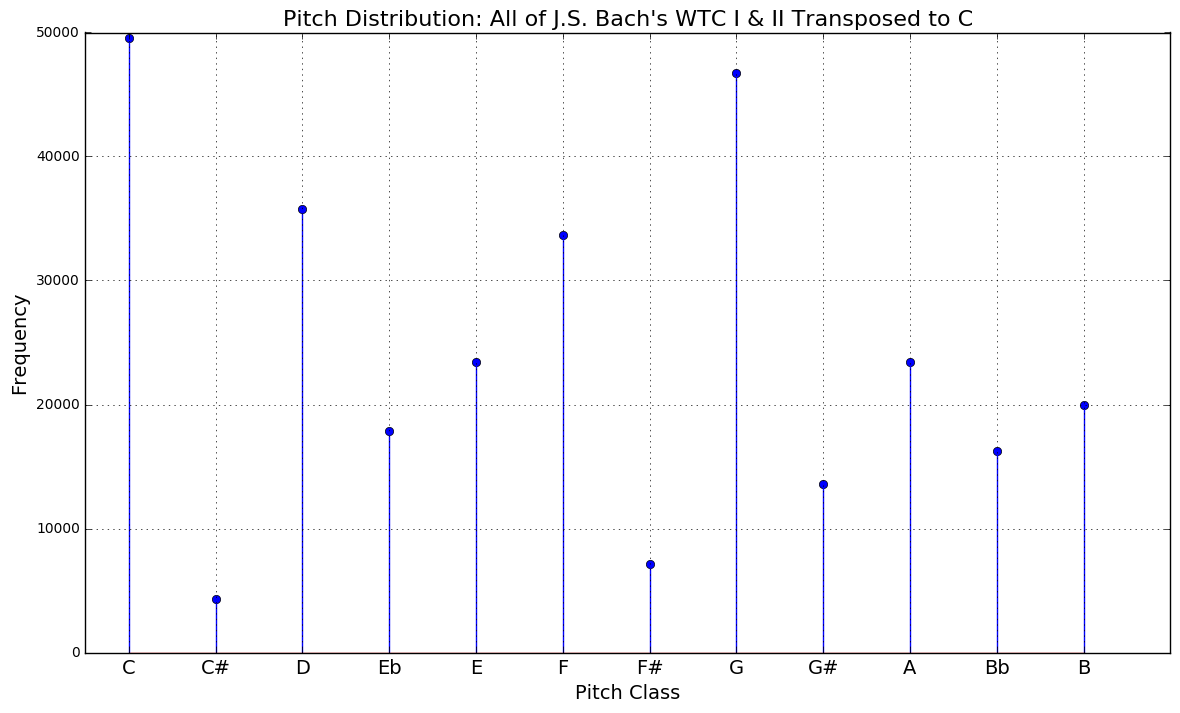

In [19]:
# The above distribution is for all works in their original keys, so it is relatively flat
# and not at all like the pitch distributions of Krumhansl and the note frequency charts we saw in class.
# What we need to do is transpose each work from its original key into C Major, so that we can look
# at pitch-class usage as RELATIVE to the KEY of each work, integrated across all works.

shifts = tile(repeat(arange(0,-12,-1),4),2) # Transpositions to C Major for every work
# The following line 'rolls' the columns (axis=0) by the transpositions, then splits octaves and sums them
# which folds all the octaves into one octave
allworks_transposed = hstack([fold_octaves(roll(s,t,axis=0)) for s,t in zip(allworks,shifts)])
# Show pitch distribution of the one-octave folded, C-transposed WTC I and II 
pd = pitch_distribution(allworks_transposed, "All of J.S. Bach's WTC I & II Transposed to C")

<h1>Question 1: Pitch distributions of Major Preludes, Minor Preludes, Major Fugues, Minor Fugures</h1>

A. Generate separate pitch distribution plots for each of the following:
    1. Major Preludes
    2. Minor Preludes
    3. Major Fugues
    4. Minor Fugues
    
B. 
    1. How well do the pitch distributions match with those of Prince and Schumuckler
"The Tonal-Metric Hierarchy: A Corpus Analysis", <i>Music Perception</i> 31(3):254-270 · February 2014
    2. How would you quantify the 'closeness' of the pitch distributions for each of the categories 1-4 above in WTC with the empirical distributions of classical music found in Prince and Schumuckler?
    3. OPTIONAL (GRADUATES) : go ahead and quantify the closeness between each of the categories of pitch distribution 1-4 with the distributions of Prince and Schumuckler.